# Autoregressive Moving Average (ARMA) Model and Hyperpameter Tuning

In [13]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df_airline=pd.read_csv('airline_passengers.csv')
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [4]:
df_airline.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [5]:
# Drop the NaN

df_airline.dropna(axis=0,inplace=True)

In [6]:
# Check for NaN Values

df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [7]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [8]:
# Let's convert to date time

df_airline['Month']=pd.to_datetime(df_airline['Month'])

In [9]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [10]:
df_airline.head()

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


**From the above we can see that we have column index starting from `0`. We need to convert the `Month` column to index. Converting the date column to an index creates a DateTimeIndex, which allows pandas to treat the data as a time series. This enables efficient time-based operations like slicing by date, aggregating data over time periods, and using time series-specific plotting tools.**

In [11]:
# Ler's convert date to index

df_airline.set_index('Month',inplace=True)

In [12]:
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [14]:
y = df_airline['Thousands of Passengers']
y.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: Thousands of Passengers, dtype: float64

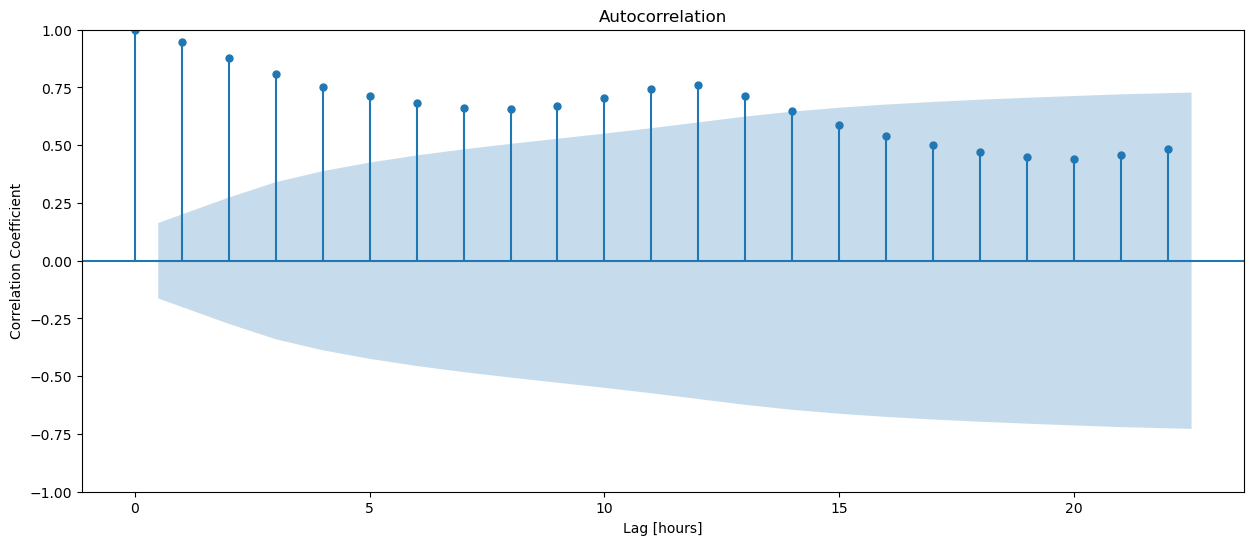

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

### The real to determine how many lags are needed comes from the PACF.

PACF removes the ecoes that are common as you progress along the dataset.

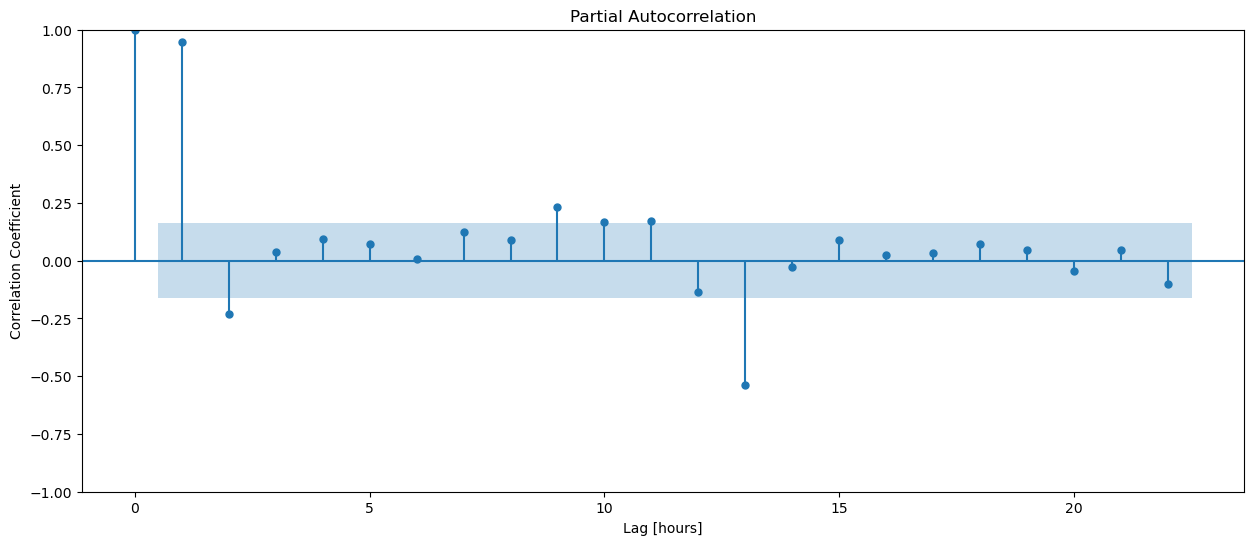

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [18]:
y.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: Thousands of Passengers, dtype: float64

# Split

In [19]:
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

# Build Baseline Model

In [20]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("Thousands of Passengers:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Thousands of Passengers: 267.18
Baseline MAE: 91.52


### Hyperparameters
Parameters in a machine learning model are values the model learns directly from the training data. In contrast, hyperparameters are not learned; they are external settings defined by the data scientist or determined through automated testing. These settings are established before training begins and play a critical role in influencing the model's training process and performance. Simply put, parameters are intrinsic to the model, while hyperparameters are externally specified.

When discussing hyperparameters in time series models, two key values often come up: **p** and **q**. The **p-value** represents the number of lagged observations included in the model, while the **q-value** specifies the size of the moving average window. These values are hyperparameters because we have the flexibility to choose them. For example, how many lagged observations should we include? How large should our moving average window be? These decisions are central to tailoring the model to the specific problem at hand.

---

### Rolling Averages
A rolling average is the mean of overlapping subsets of data within a dataset, calculated continuously over a defined window. For instance, if I own a shop and record daily income, I can compute a rolling average to track trends. On Friday, I might calculate the average income for Monday through Thursday. By the following Monday, the rolling average would update to reflect Tuesday through Friday, and so forth. This moving calculation adapts as new data is added, allowing for a dynamic understanding of how the dataset evolves over time.

Rolling averages are particularly valuable for time-series data, as they provide insights into trends and patterns without being influenced by short-term fluctuations. By smoothing the data in this way, we can make more reliable predictions about how the dataset will behave in the future.

## Let's get the p and q

**We are using 13 as the range of p values as suggested by our PACF**

In [21]:
p_params = range(0,13,4)
q_params = range(0,3,1)

In [22]:
for p in p_params:
    for q in q_params:
        order = (p, 0, q)
        print(order)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(4, 0, 0)
(4, 0, 1)
(4, 0, 2)
(8, 0, 0)
(8, 0, 1)
(8, 0, 2)
(12, 0, 0)
(12, 0, 1)
(12, 0, 2)


In [25]:
for p in p_params:
    for q in q_params:
        order = (p, 0, q)
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        print(f"Trained ARIMA {order}")

/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py

Trained ARIMA (0, 0, 0)
Trained ARIMA (0, 0, 1)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/stats

Trained ARIMA (0, 0, 2)
Trained ARIMA (4, 0, 0)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Trained ARIMA (4, 0, 1)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chukwuemeka-james/anaconda3/lib/python3.12/si

Trained ARIMA (4, 0, 2)
Trained ARIMA (8, 0, 0)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Trained ARIMA (8, 0, 1)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/ts

Trained ARIMA (8, 0, 2)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/ts

Trained ARIMA (12, 0, 0)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/ts

Trained ARIMA (12, 0, 1)
Trained ARIMA (12, 0, 2)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
# Set explicit frequency
y_train.index = pd.date_range(start=y_train.index[0], end=y_train.index[-1], freq='MS')

# Create dictionary to store MAEs
mae_grid = {}
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = []
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)


Trained ARIMA (0, 0, 0) in 0.08 seconds.
Trained ARIMA (0, 0, 1) in 0.13 seconds.


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (0, 0, 2) in 0.16 seconds.
Trained ARIMA (4, 0, 0) in 0.19 seconds.
Trained ARIMA (4, 0, 1) in 0.4 seconds.


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 2) in 1.06 seconds.
Trained ARIMA (8, 0, 0) in 0.76 seconds.
Trained ARIMA (8, 0, 1) in 0.65 seconds.


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (8, 0, 2) in 1.69 seconds.


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (12, 0, 0) in 2.49 seconds.


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (12, 0, 1) in 1.62 seconds.
Trained ARIMA (12, 0, 2) in 1.79 seconds.


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
mae_grid

{0: [91.52086914961305, 49.166011349133306, 39.25350664881461],
 4: [23.655937285749033, 23.157091719463853, 22.31284044146318],
 8: [21.886130249278327, 22.14902880647705, 19.945237955181145],
 12: [16.45759570948141, 15.699853008845185, 12.540717881881873]}

In [30]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)


,0,4,8,12
0,91.5209,23.6559,21.8861,16.4576
1,49.1660,23.1571,22.1490,15.6999
2,39.2535,22.3128,19.9452,12.5407


**From the above output we can note the following**

- Possible values of p `0,	4,	8,	12`
- Possible values of q `0,  1,  2`
- Bellow are the MAE for values trained with corresponding hyperparameter

`91.5209,	23.6559,	21.8861,	16.4576`

`49.1660,	23.1571,	22.1490,	15.6999`

`39.2535,	22.3128,	19.9452,	12.5407`

**From what we have (p=12, q=2) Give the best result in `Trained ARIMA (12, 0, 2) in 1.79 seconds.` followed by (p=12, q=1) `Trained ARIMA (12, 0, 1) in 1.62 seconds.`**

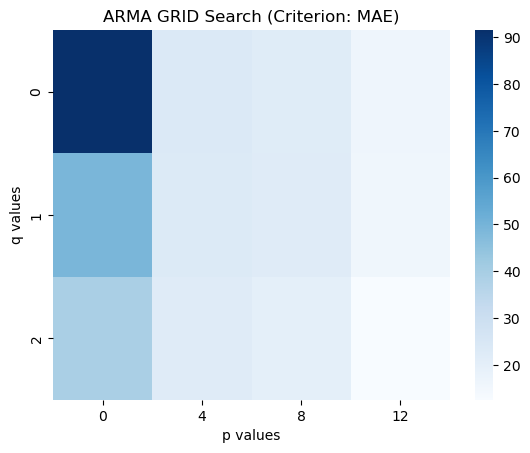

In [36]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA GRID Search (Criterion: MAE)");

### Note the lower the MAE the better the model perfomance. The lighter blues here represent lower MAE.

# Residual

Let's the residuals using the `plot_diagnostic()` method.

<Figure size 1800x1400 with 0 Axes>

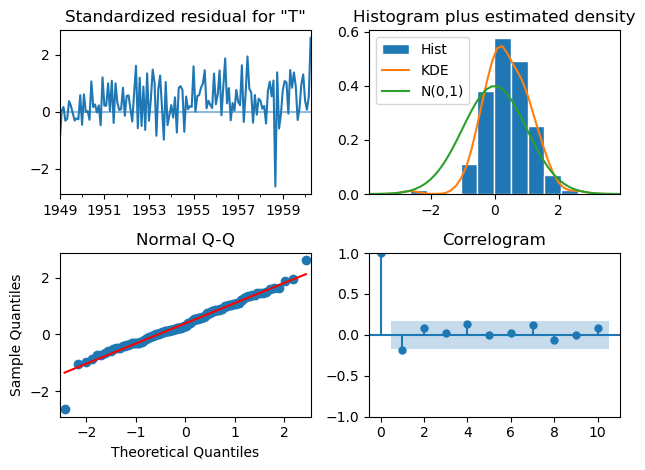

In [42]:
# Increase figure size
fig = plt.figure(figsize=(18, 14))

# Plot diagnostics (no ax argument needed)
model.plot_diagnostics()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Evaluate the model

In [54]:
y_pred_wfv = pd.Series(dtype=float)  # Initialize an empty Series
history = y_train.copy()

for i in range(len(y_test)):
    model = ARIMA(history, order=(12, 0, 2)).fit()
    next_pred = model.forecast()
    # Use pd.concat instead of append
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    # Update the history with the observed value
    history = pd.concat([history, y_test[next_pred.index]])

print(y_pred_wfv)


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/tmp/ipykernel_6072/1942186423.py:8: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473:

1960-05-01    486.168163
1960-06-01    495.927429
1960-07-01    590.123241
1960-08-01    592.151203
1960-09-01    537.741155
1960-10-01    417.836538
1960-11-01    424.010472
1960-12-01    409.143559
Freq: MS, dtype: float64


/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



### We can change the values in the order to see if there is osmething better.

In [55]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 28.59


### Communicate Results



In [56]:
df_predictions = pd.DataFrame({"y_test":y_test,"y_pred_wfv":y_pred_wfv})
fig = px.line(df_predictions, labels = {"values": "Thousands of Passengers"})
fig.show()

### From the above we can see the relationship between real label blue and our models output in red.